In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from transforms3d.euler import euler2mat

In [2]:
def inverse_kinematics(x: float, y: float, z: float, a1: float, a2: float):
    y_prime = -math.sqrt((z)**2 + y**2)
    thetaz = math.atan2(abs(y), z)

    c2 = (x**2 + y_prime**2 - a1**2 - a2**2) / (2 * a1 * a2)
    s2 = math.sqrt(abs(1 - c2**2))
    theta2 = math.atan2(s2, c2)

    c1 = (x * (a1 + (a2 * c2)) + y_prime * (a2 * s2)) / (x**2 + y_prime**2)
    s1 = (y_prime * (a1 + (a2 * c2)) - x * (a2 * s2)) / (x**2 + y_prime**2)
    theta1 = math.atan2(s1, c1)

    theta_shoulder = -theta1
    theta_elbow = theta_shoulder - theta2
    theta_hip = thetaz

    return math.degrees(theta_shoulder), math.degrees(theta_elbow), math.degrees(theta_hip)

In [3]:
# 設定機器狗的參數
body_length = 20  # 前後腿間距 (X 軸)
body_width = 15   # 左右腿間距 (Z 軸)
leg_upper_length = 10  # 大腿長度 (Y 軸)
leg_lower_length = 10  # 小腿長度 (Y 軸)
stand_height = 15  # 站立高度 (肩部到地面)

# 機器狗的肩部位置 (X, Z, Y)
shoulder_positions = np.asfortranarray([
    [body_length / 2, body_length / 2, -body_length / 2, -body_length / 2],
    [-body_width / 2, body_width / 2, -body_width / 2, body_width / 2],
    [0, 0, 0, 0],
])

# 計算膝部和腳端位置（使用逆向運動學）
knee_positions = np.zeros_like(shoulder_positions)
foot_positions = np.zeros_like(shoulder_positions)

for i in range(4):
    x, z, y = shoulder_positions[:,i]
    theta_shoulder, theta_elbow, theta_hip = inverse_kinematics(0, -stand_height, 0, leg_upper_length, leg_lower_length)
    print("theta: ", theta_shoulder, theta_elbow, theta_hip)

    knee_x = x + leg_upper_length * math.cos(math.radians(theta_shoulder))
    knee_y = y - leg_upper_length * math.sin(math.radians(theta_shoulder))
    knee_z = z + leg_upper_length * math.sin(math.radians(90 - theta_hip))
    foot_x = knee_x + leg_lower_length * math.cos(math.radians(theta_elbow))
    foot_y = knee_y - leg_lower_length * math.sin(math.radians(theta_elbow))
    foot_z = knee_z + leg_lower_length * math.sin(math.radians(90 - theta_hip))
    print("x: ", x, "knee_x: ", knee_x, "foot_x: ", foot_x)
    print("y: ", y, "knee_y: ", knee_y, "foot_y: ", foot_y)
    print("z: ", z, "knee_z: ", knee_z, "foot_z: ", foot_z)
    knee_positions[:,i] = [knee_x, knee_z, knee_y]
    
    foot_positions[:,i] = [foot_x, foot_z, foot_y]

theta:  131.40962210927086 48.59037789072913 90.0
x:  10.0 knee_x:  3.3856217223385245 foot_x:  10.000000000000004
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  10.0 knee_x:  3.3856217223385245 foot_x:  10.000000000000004
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  7.5 knee_z:  7.5 foot_z:  7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  -10.0 knee_x:  -16.614378277661476 foot_x:  -9.999999999999998
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
theta:  131.40962210927086 48.59037789072913 90.0
x:  -10.0 knee_x:  -16.614378277661476 foot_x:  -9.999999999999998
y:  0.0 knee_y:  -7.500000000000001 foot_y:  -15.0
z:  7.5 knee_z:  7.5 foot_z:  7.5


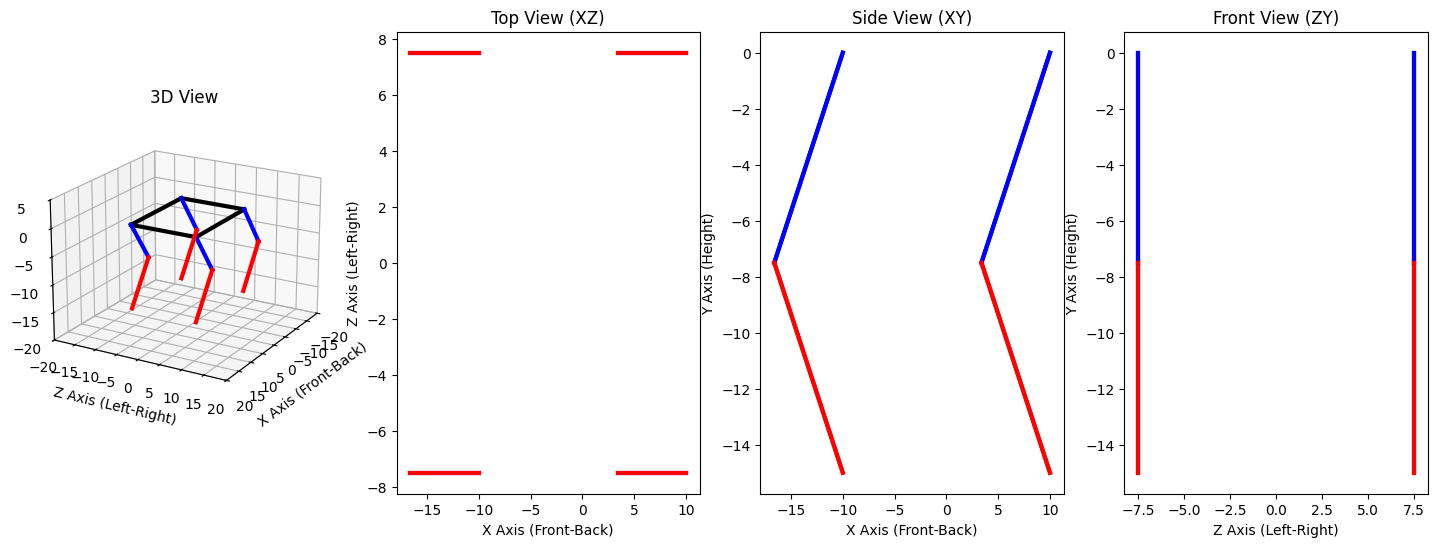

In [4]:
# 繪製 3D 及 3 個 2D 視角的機器狗模型
fig = plt.figure(figsize=(18, 6))

# 3D 視圖
ax3d = fig.add_subplot(141, projection='3d')
ax3d.set_title("3D View")
ax3d.set_xlabel("X Axis (Front-Back)")
ax3d.set_ylabel("Z Axis (Left-Right)")
ax3d.set_zlabel("Y Axis (Height)")
ax3d.set_xlim(-20,20)
ax3d.xaxis.set_major_locator(MultipleLocator(5))
ax3d.set_ylim(-20,20)
ax3d.yaxis.set_major_locator(MultipleLocator(5))
ax3d.set_zlim(-20,5)
ax3d.view_init(elev=20, azim=30)

# XZ 平面 (正視圖)
ax_xz = fig.add_subplot(142)
ax_xz.set_title("Top View (XZ)")
ax_xz.set_xlabel("X Axis (Front-Back)")
ax_xz.set_ylabel("Z Axis (Left-Right)")

# XY 平面 (側視圖)
ax_xy = fig.add_subplot(143)
ax_xy.set_title("Side View (XY)")
ax_xy.set_xlabel("X Axis (Front-Back)")
ax_xy.set_ylabel("Y Axis (Height)")

# ZY 平面 (俯視圖)
ax_zy = fig.add_subplot(144)
ax_zy.set_title("Front View (ZY)")
ax_zy.set_xlabel("Z Axis (Left-Right)")
ax_zy.set_ylabel("Y Axis (Height)")

# 繪製 3D 身體
body_lines = [
    (shoulder_positions[:, 0], shoulder_positions[:, 1]),
    (shoulder_positions[:, 2], shoulder_positions[:, 3]),
    (shoulder_positions[:, 0], shoulder_positions[:, 2]),
    (shoulder_positions[:, 1], shoulder_positions[:, 3]),
]

for line in body_lines:
    ax3d.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], 'k-', lw=3)

# 繪製 3D 腿部
for i in range(4):
    ax3d.plot(
        [shoulder_positions[0, i], knee_positions[0, i]],
        [shoulder_positions[1, i], knee_positions[1, i]],
        [shoulder_positions[2, i], knee_positions[2, i]],
        'b-', lw=3)  # 大腿

    ax3d.plot(
        [knee_positions[0, i], foot_positions[0, i]],
        [knee_positions[1, i], foot_positions[1, i]],
        [knee_positions[2, i], foot_positions[2, i]],
        'r-', lw=3)  # 小腿

# 繪製 XZ 平面
for i in range(4):
    ax_xz.plot([shoulder_positions[0, i], knee_positions[0, i]], [shoulder_positions[1, i], knee_positions[1, i]], 'b-', lw=3)  # 大腿
    ax_xz.plot([knee_positions[0, i], foot_positions[0, i]], [knee_positions[1, i], foot_positions[1, i]], 'r-', lw=3)  # 小腿

# 繪製 XY 平面
for i in range(4):
    ax_xy.plot([shoulder_positions[0, i], knee_positions[0, i]], [shoulder_positions[2, i], knee_positions[2, i]], 'b-', lw=3)  # 大腿
    ax_xy.plot([knee_positions[0, i], foot_positions[0, i]], [knee_positions[2, i], foot_positions[2, i]], 'r-', lw=3)  # 小腿

# 繪製 ZY 平面
for i in range(4):
    ax_zy.plot([shoulder_positions[1, i], knee_positions[1, i]], [shoulder_positions[2, i], knee_positions[2, i]], 'b-', lw=3)  # 大腿
    ax_zy.plot([knee_positions[1, i], foot_positions[1, i]], [knee_positions[2, i], foot_positions[2, i]], 'r-', lw=3)  # 小腿

plt.show()


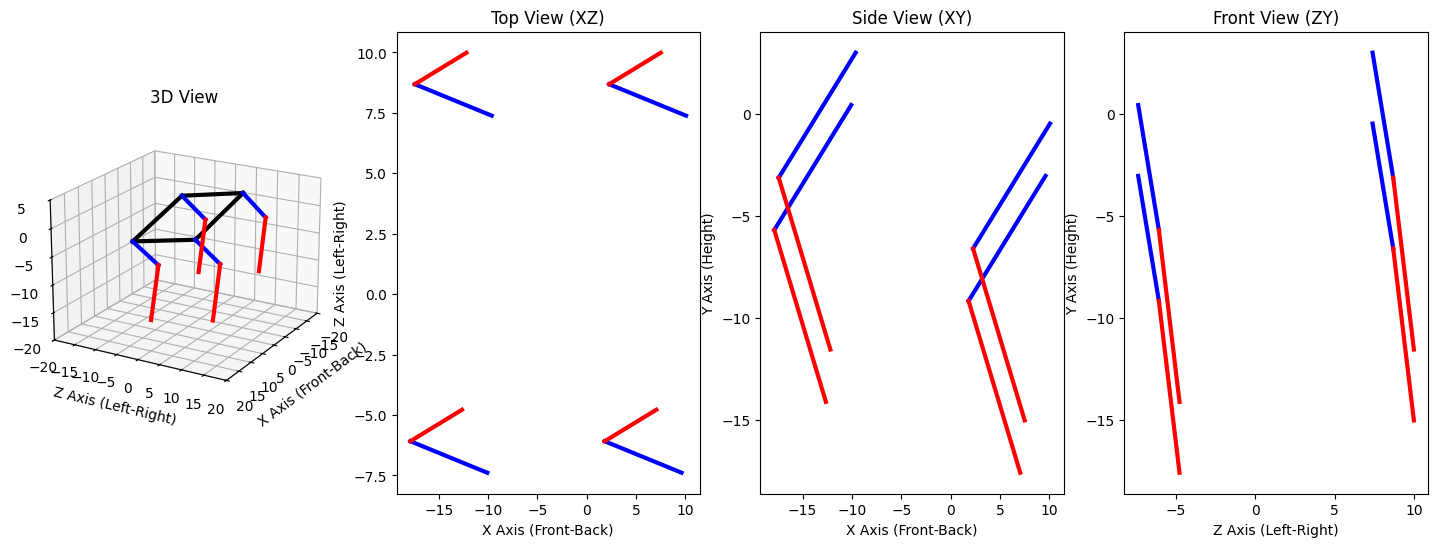

In [5]:
R = euler2mat(math.radians(10),math.radians(10),0)
gyro_shoulder_positions = R @ shoulder_positions
gyro_body_lines = [
    (gyro_shoulder_positions[:, 0], gyro_shoulder_positions[:, 1]),
    (gyro_shoulder_positions[:, 2], gyro_shoulder_positions[:, 3]),
    (gyro_shoulder_positions[:, 0], gyro_shoulder_positions[:, 2]),
    (gyro_shoulder_positions[:, 1], gyro_shoulder_positions[:, 3]),
]

gyro_knee_positions = R @ knee_positions
gyro_foot_positions = R @ foot_positions

fig = plt.figure(figsize=(18, 6))
gyro_ax3d = fig.add_subplot(141, projection='3d')
gyro_ax3d.set_title("3D View")
gyro_ax3d.set_xlabel("X Axis (Front-Back)")
gyro_ax3d.set_ylabel("Z Axis (Left-Right)")
gyro_ax3d.set_zlabel("Y Axis (Height)")
gyro_ax3d.set_xlim(-20,20)
gyro_ax3d.xaxis.set_major_locator(MultipleLocator(5))
gyro_ax3d.set_ylim(-20,20)
gyro_ax3d.yaxis.set_major_locator(MultipleLocator(5))
gyro_ax3d.set_zlim(-20,5)
gyro_ax3d.view_init(elev=20, azim=30)

# XZ 平面 (正視圖)
gyro_ax_xz = fig.add_subplot(142)
gyro_ax_xz.set_title("Top View (XZ)")
gyro_ax_xz.set_xlabel("X Axis (Front-Back)")
gyro_ax_xz.set_ylabel("Z Axis (Left-Right)")

# XY 平面 (側視圖)
gyro_ax_xy = fig.add_subplot(143)
gyro_ax_xy.set_title("Side View (XY)")
gyro_ax_xy.set_xlabel("X Axis (Front-Back)")
gyro_ax_xy.set_ylabel("Y Axis (Height)")

# ZY 平面 (俯視圖)
gyro_ax_zy = fig.add_subplot(144)
gyro_ax_zy.set_title("Front View (ZY)")
gyro_ax_zy.set_xlabel("Z Axis (Left-Right)")
gyro_ax_zy.set_ylabel("Y Axis (Height)")

for line in gyro_body_lines:
    gyro_ax3d.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], 'k-', lw=3)

for i in range(4):
    gyro_ax3d.plot(
        [gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]],
        [gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]],
        [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]],
        'b-', lw=3)  # 大腿

    gyro_ax3d.plot(
        [gyro_knee_positions[0, i], gyro_foot_positions[0, i]],
        [gyro_knee_positions[1, i], gyro_foot_positions[1, i]],
        [gyro_knee_positions[2, i], gyro_foot_positions[2, i]],
        'r-', lw=3)  # 小腿
    
# 繪製 XZ 平面
for i in range(4):
    gyro_ax_xz.plot([gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]], [gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]], 'b-', lw=3)  # 大腿
    gyro_ax_xz.plot([gyro_knee_positions[0, i], gyro_foot_positions[0, i]], [gyro_knee_positions[1, i], gyro_foot_positions[1, i]], 'r-', lw=3)  # 小腿

# 繪製 XY 平面
for i in range(4):
    gyro_ax_xy.plot([gyro_shoulder_positions[0, i], gyro_knee_positions[0, i]], [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    gyro_ax_xy.plot([gyro_knee_positions[0, i], gyro_foot_positions[0, i]], [gyro_knee_positions[2, i], gyro_foot_positions[2, i]], 'r-', lw=3)  # 小腿

# 繪製 ZY 平面
for i in range(4):
    gyro_ax_zy.plot([gyro_shoulder_positions[1, i], gyro_knee_positions[1, i]], [gyro_shoulder_positions[2, i], gyro_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    gyro_ax_zy.plot([gyro_knee_positions[1, i], gyro_foot_positions[1, i]], [gyro_knee_positions[2, i], gyro_foot_positions[2, i]], 'r-', lw=3)  # 小腿

plt.show()

In [6]:
def get_plane_from_points(p1: np.ndarray, p2: np.ndarray, p3: np.ndarray):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)

    # 計算法向量（叉積）
    normal = np.cross(v1, v2)
    A, B, C = normal

    # 計算 D
    D = -(A * p1[0] + B * p1[1] + C * p1[2])

    return A,B,C,D

In [7]:
def turn_points_with_euler_radians(points: np.ndarray, roll, pitch, yaw):
    if points.shape[0] != 3:
        raise ValueError("input points must have 3 dimension (x, z, y)")

    rotation_matrix = euler2mat(roll, pitch, yaw)

    # rotate
    rotated_points = rotation_matrix @ points
    return rotated_points

In [8]:
from enum import IntEnum
from typing import NamedTuple
from dataclasses import dataclass

class LegPosition(IntEnum):
    FL = 0  # Front Left
    FR = 1  # Front Right
    BL = 2  # Back Left
    BR = 3  # Back Right

@dataclass
class GyroData():
    roll: float = 0.0
    pitch: float = 0.0
    yaw: float = 0.0

class Position(NamedTuple):
    x: float
    y: float
    z: float

@dataclass
class FootPositions:
    FL: Position
    FR: Position
    BL: Position
    BR: Position

In [9]:
"""
Utils function:
"""
from typing import Literal

def get_np_array_from_foot_positions(foot_positions: FootPositions, order: Literal['xyz', 'xzy']='xzy') -> np.ndarray:
    """
    Convert FootPositions into a NumPy array with specified axis order.
    
    Args:
        foot_positions (FootPositions): The structure containing leg positions.
        order (Literal['xyz', 'xzy']): Determines the order of the axes.
    
    Returns:
        np.ndarray: A (3, 4) array where rows represent x, y, z coordinates and columns represent FL, FR, BL, BR.
    """
    # Extract the x, y, z coordinates into separate lists
    x = np.array([foot_positions.FL.x, foot_positions.FR.x, foot_positions.BL.x, foot_positions.BR.x], dtype=np.float64)
    y = np.array([foot_positions.FL.y, foot_positions.FR.y, foot_positions.BL.y, foot_positions.BR.y], dtype=np.float64)
    z = np.array([foot_positions.FL.z, foot_positions.FR.z, foot_positions.BL.z, foot_positions.BR.z], dtype=np.float64)

    if order == 'xyz':
        return np.vstack([x, y, z])
    elif order == 'xzy':
        return np.vstack([x, z, y])
    else:
        raise ValueError("Invalid order. Use 'xyz' or 'xzy'.")

def get_foot_positions_from_np_array(positions: np.ndarray, order: Literal['xyz', 'xzy']='xzy') -> FootPositions:
    if positions.shape != (3, 4):
        raise ValueError("Invalid shape for positions array. Expected (3, 4).")
    
    if order == 'xyz':
        x, y, z = positions
    elif order == 'xzy':
        x, z, y = positions
    else:
        raise ValueError("Invalid order. Use 'xyz' or 'xzy'.")
    
    return FootPositions(
        FL=Position(x[0], y[0], z[0]),
        FR=Position(x[1], y[1], z[1]),
        BL=Position(x[2], y[2], z[2]),
        BR=Position(x[3], y[3], z[3])
    )

In [10]:
def compensate_foot_positions_by_gyro(foot_positions_FP: FootPositions, gyro_data: GyroData, max_height=15.0) -> FootPositions:
    local_foot_positions = get_np_array_from_foot_positions(foot_positions_FP, order='xzy')
    foot_positions = local_foot_positions.copy()
    foot_positions[0,:] += shoulder_positions[0,:]
    foot_positions[1,:] += shoulder_positions[1,:]
    gyro_foot_positions = turn_points_with_euler_radians(foot_positions, math.radians(gyro_data.roll), math.radians(gyro_data.pitch), 0)
    # A * x + B * z + C * y + D = 0
    A, B, C, D = get_plane_from_points(gyro_foot_positions[:,0], gyro_foot_positions[:,1], gyro_foot_positions[:,2])

    compensated_foot_positions = local_foot_positions.copy()
    for leg_position in LegPosition:
        compensated_foot_positions[2,leg_position] += -(A*shoulder_positions[0,leg_position] + B*shoulder_positions[1,leg_position,]+D)/C - (-max_height)

    compensated_foot_positions_FP = get_foot_positions_from_np_array(compensated_foot_positions)
    return compensated_foot_positions_FP

In [11]:
gyro_data = GyroData(roll=10, pitch=10, yaw=0)

temp = compensate_foot_positions_by_gyro(get_foot_positions_from_np_array(foot_positions), gyro_data=gyro_data)
print(temp)
compensated_foot_positions = get_np_array_from_foot_positions(temp)


compensated_foot_positions

FootPositions(FL=Position(x=np.float64(10.000000000000004), y=np.float64(-18.5724911835074), z=np.float64(-7.5)), FR=Position(x=np.float64(10.000000000000004), y=np.float64(-15.886784554434803), z=np.float64(7.5)), BL=Position(x=np.float64(-9.999999999999998), y=np.float64(-15.0459515693381), z=np.float64(-7.5)), BR=Position(x=np.float64(-9.999999999999998), y=np.float64(-12.360244940265504), z=np.float64(7.5)))


array([[ 10.        ,  10.        , -10.        , -10.        ],
       [ -7.5       ,   7.5       ,  -7.5       ,   7.5       ],
       [-18.57249118, -15.88678455, -15.04595157, -12.36024494]])

In [12]:
compensated_shoulder_positions = shoulder_positions.copy()
compensated_knee_positions = np.zeros_like(compensated_shoulder_positions)

for i in range(4):
    x, z, y = compensated_shoulder_positions[:,i]
    print(compensated_foot_positions[2,i])
    theta_shoulder, theta_elbow, theta_hip = inverse_kinematics(0, compensated_foot_positions[2,i], 0, leg_upper_length, leg_lower_length)
    print("theta: ", theta_shoulder, theta_elbow, theta_hip)

    compensated_knee_x = x + leg_upper_length * math.cos(math.radians(theta_shoulder))
    compensated_knee_y = y - leg_upper_length * math.sin(math.radians(theta_shoulder))
    compensated_knee_z = z + leg_upper_length * math.sin(math.radians(90 - theta_hip))
    compensated_foot_x = compensated_knee_x + leg_lower_length * math.cos(math.radians(theta_elbow))
    compensated_foot_y = compensated_knee_y - leg_lower_length * math.sin(math.radians(theta_elbow))
    compensated_foot_z = compensated_knee_z + leg_lower_length * math.sin(math.radians(90 - theta_hip))
    print("x: ", x, "knee_x: ", compensated_knee_x, "foot_x: ", compensated_foot_x)
    print("y: ", y, "knee_y: ", compensated_knee_y, "foot_y: ", compensated_foot_y)
    print("z: ", z, "knee_z: ", compensated_knee_z, "foot_z: ", compensated_foot_z)
    compensated_knee_positions[:,i] = [compensated_knee_x, compensated_knee_z, compensated_knee_y]
    
    compensated_foot_positions[:,i] = [compensated_foot_x, compensated_foot_z, compensated_foot_y]

-18.5724911835074
theta:  111.77858594658645 68.22141405341355 90.0
x:  10.0 knee_x:  6.289792079999425 foot_x:  10.0
y:  0.0 knee_y:  -9.2862455917537 foot_y:  -18.5724911835074
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
-15.886784554434803
theta:  127.40711147720421 52.5928885227958 90.0
x:  10.0 knee_x:  3.9252556325189323 foot_x:  10.0
y:  0.0 knee_y:  -7.9433922772174 foot_y:  -15.8867845544348
z:  7.5 knee_z:  7.5 foot_z:  7.5
-15.0459515693381
theta:  131.21020489173455 48.789795108265444 90.0
x:  -10.0 knee_x:  -16.588234615075805 foot_x:  -9.999999999999998
y:  0.0 knee_y:  -7.52297578466905 foot_y:  -15.0459515693381
z:  -7.5 knee_z:  -7.5 foot_z:  -7.5
-12.360244940265504
theta:  141.82887692303925 38.171123076960775 90.0
x:  -10.0 knee_x:  -17.861684695671805 foot_x:  -10.000000000000004
y:  0.0 knee_y:  -6.18012247013275 foot_y:  -12.360244940265503
z:  7.5 knee_z:  7.5 foot_z:  7.5


In [13]:
A, B, C, D = get_plane_from_points(gyro_shoulder_positions[:,0], gyro_shoulder_positions[:,1], gyro_shoulder_positions[:,2])
calculated_A, calculated_B, calculated_C, calculated_D = get_plane_from_points(compensated_foot_positions[:,0], compensated_foot_positions[:,1], compensated_foot_positions[:,2])

print("Original: A=", A, ", B=", B, ", C=", C, ", D=", D)
print("Calculated: A=", calculated_A, ", B=", calculated_B, ", C=", calculated_C, ", D=", calculated_D)

Original: A= 51.303021498850306 , B= -52.094453300079095 , C= 290.95389311788625 , D= -0.0
Calculated: A= 52.898094212539476 , B= -53.71413258145196 , C= 300.0 , D= 4639.910418565935


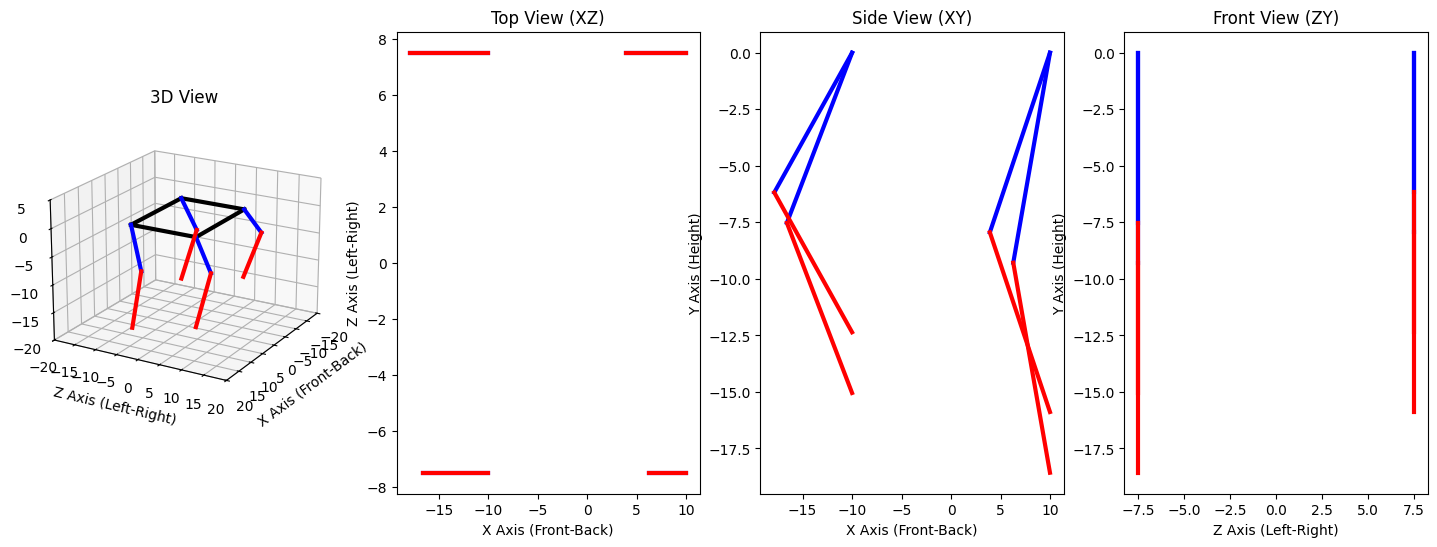

In [14]:
# 繪製 3D 及 3 個 2D 視角的機器狗模型
fig = plt.figure(figsize=(18, 6))

# 3D 視圖
comp_ax3d = fig.add_subplot(141, projection='3d')
comp_ax3d.set_title("3D View")
comp_ax3d.set_xlabel("X Axis (Front-Back)")
comp_ax3d.set_ylabel("Z Axis (Left-Right)")
comp_ax3d.set_zlabel("Y Axis (Height)")
comp_ax3d.set_xlim(-20,20)
comp_ax3d.xaxis.set_major_locator(MultipleLocator(5))
comp_ax3d.set_ylim(-20,20)
comp_ax3d.yaxis.set_major_locator(MultipleLocator(5))
comp_ax3d.set_zlim(-20,5)
comp_ax3d.view_init(elev=20, azim=30)

# XZ 平面 (正視圖)
comp_ax_xz = fig.add_subplot(142)
comp_ax_xz.set_title("Top View (XZ)")
comp_ax_xz.set_xlabel("X Axis (Front-Back)")
comp_ax_xz.set_ylabel("Z Axis (Left-Right)")

# XY 平面 (側視圖)
comp_ax_xy = fig.add_subplot(143)
comp_ax_xy.set_title("Side View (XY)")
comp_ax_xy.set_xlabel("X Axis (Front-Back)")
comp_ax_xy.set_ylabel("Y Axis (Height)")

# ZY 平面 (俯視圖)
comp_ax_zy = fig.add_subplot(144)
comp_ax_zy.set_title("Front View (ZY)")
comp_ax_zy.set_xlabel("Z Axis (Left-Right)")
comp_ax_zy.set_ylabel("Y Axis (Height)")

# 繪製 3D 身體
comp_body_lines = [
    (compensated_shoulder_positions[:, 0], compensated_shoulder_positions[:, 1]),
    (compensated_shoulder_positions[:, 2], compensated_shoulder_positions[:, 3]),
    (compensated_shoulder_positions[:, 0], compensated_shoulder_positions[:, 2]),
    (compensated_shoulder_positions[:, 1], compensated_shoulder_positions[:, 3]),
]

for line in comp_body_lines:
    comp_ax3d.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], [line[0][2], line[1][2]], 'k-', lw=3)

# 繪製 3D 腿部
for i in range(4):
    comp_ax3d.plot(
        [compensated_shoulder_positions[0, i], compensated_knee_positions[0, i]],
        [compensated_shoulder_positions[1, i], compensated_knee_positions[1, i]],
        [compensated_shoulder_positions[2, i], compensated_knee_positions[2, i]],
        'b-', lw=3)  # 大腿

    comp_ax3d.plot(
        [compensated_knee_positions[0, i], compensated_foot_positions[0, i]],
        [compensated_knee_positions[1, i], compensated_foot_positions[1, i]],
        [compensated_knee_positions[2, i], compensated_foot_positions[2, i]],
        'r-', lw=3)  # 小腿

# 繪製 XZ 平面
for i in range(4):
    comp_ax_xz.plot([compensated_shoulder_positions[0, i], compensated_knee_positions[0, i]], [compensated_shoulder_positions[1, i], compensated_knee_positions[1, i]], 'b-', lw=3)  # 大腿
    comp_ax_xz.plot([compensated_knee_positions[0, i], compensated_foot_positions[0, i]], [compensated_knee_positions[1, i], compensated_foot_positions[1, i]], 'r-', lw=3)  # 小腿

# 繪製 XY 平面
for i in range(4):
    comp_ax_xy.plot([compensated_shoulder_positions[0, i], compensated_knee_positions[0, i]], [compensated_shoulder_positions[2, i], compensated_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    comp_ax_xy.plot([compensated_knee_positions[0, i], compensated_foot_positions[0, i]], [compensated_knee_positions[2, i], compensated_foot_positions[2, i]], 'r-', lw=3)  # 小腿

# 繪製 ZY 平面
for i in range(4):
    comp_ax_zy.plot([compensated_shoulder_positions[1, i], compensated_knee_positions[1, i]], [compensated_shoulder_positions[2, i], compensated_knee_positions[2, i]], 'b-', lw=3)  # 大腿
    comp_ax_zy.plot([compensated_knee_positions[1, i], compensated_foot_positions[1, i]], [compensated_knee_positions[2, i], compensated_foot_positions[2, i]], 'r-', lw=3)  # 小腿

plt.show()


In [15]:
leg_position = 0
gyro_foot_positions = turn_points_with_euler_radians(foot_positions, math.radians(10), math.radians(10), 0)
foot_A, foot_B, foot_C, foot_D = get_plane_from_points(gyro_foot_positions[:,0],gyro_foot_positions[:,1], gyro_foot_positions[:,2])

compensation_height = foot_positions[2,:].copy()
print(foot_A, foot_B, foot_C, foot_D)
for leg_position in LegPosition:
    compensation_height[leg_position] = -(foot_A*shoulder_positions[0,leg_position] + foot_B*shoulder_positions[1,leg_position]+foot_D)/foot_C
print(compensation_height)

51.303021498850285 -52.09445330007909 290.95389311788625 4499.999999999999
[-18.57249118 -15.88678455 -15.04595157 -12.36024494]


In [16]:
print(shoulder_positions)

print(compensated_foot_positions)

[[ 10.   10.  -10.  -10. ]
 [ -7.5   7.5  -7.5   7.5]
 [  0.    0.    0.    0. ]]
[[ 10.          10.         -10.         -10.        ]
 [ -7.5          7.5         -7.5          7.5       ]
 [-18.57249118 -15.88678455 -15.04595157 -12.36024494]]
